In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from evallm.enumerate_dfa.enumerate import unpack_dfa
from evallm.experiments.exhaustive_transducer_experiment import (
    current_exhaustive_experiment,
)

In [4]:
summary = {
    k: v[0] for k, v in current_exhaustive_experiment(1).items() if v[0] is not None
}
pdfas = sorted(summary)

In [5]:
model_res_no_nan = [
    100
    * summary[pdfa].model_summary[1]
    / (summary[pdfa].model_summary[0] + summary[pdfa].model_summary[1])
    for pdfa in pdfas
]
model_res_nan_bad = np.array(
    [
        100 * summary[pdfa].model_summary[1] / sum(summary[pdfa].model_summary.values())
        for pdfa in pdfas
    ]
)
result_5gram = [100 * summary[pdfa].ngram_each[5 - 1] for pdfa in pdfas]

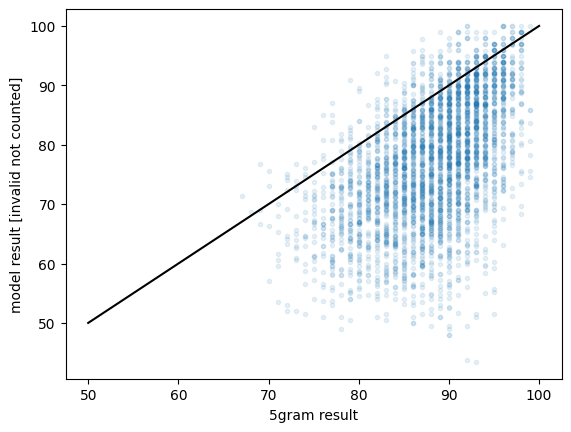

In [6]:
plt.scatter(result_5gram, model_res_no_nan, alpha=0.1, marker=".")
plt.plot([50, 100], [50, 100], color="black")
plt.xlabel("5gram result")
plt.ylabel("model result [invalid not counted]")
plt.show()

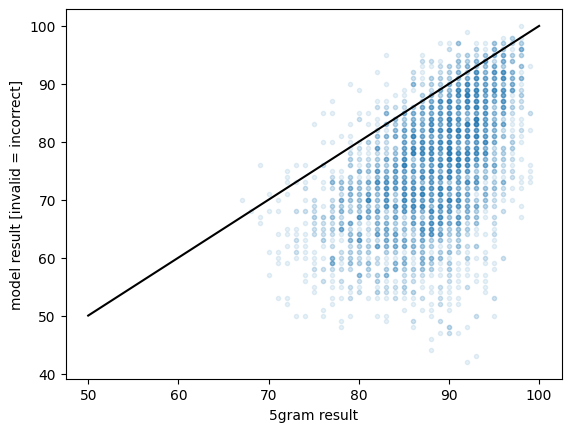

In [7]:
plt.scatter(result_5gram, model_res_nan_bad, alpha=0.1, marker=".")
plt.plot([50, 100], [50, 100], color="black")
plt.xlabel("5gram result")
plt.ylabel("model result [invalid = incorrect]")
plt.show()

In [8]:
sorted_by_model_result = np.argsort(model_res_nan_bad)

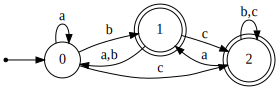

In [9]:
unpack_dfa(pdfas[sorted_by_model_result[0]])

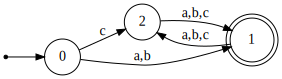

In [10]:
unpack_dfa(pdfas[sorted_by_model_result[-1]])